In [3]:
import numpy as np
import tqdm 
import matplotlib.pyplot as plt
from astropy.constants import G
import matplotlib as mpl
import sys
from scipy import interpolate
from scipy.integrate import simps
from matplotlib import colors 

sys.path.append('../my_funcs/')
from pipeline_main import pipeline, dist

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

In [4]:
data = pipeline(snap = 357, run = 'my_core_13lacc', sink_id=13)
data.recalc_L(verbose = 1); 
data.calc_disksize(plot = False); data.calc_trans_xyz()

Initialising patch data


100%|██████████| 4165/4165 [00:03<00:00, 1282.43it/s]


Converged mean angular momentum vector after 0 iteration(s)
Looping through patches, assigning azimuthal velocities to all cells and extracing them within given cylindrical coordiantes


100%|██████████| 4165/4165 [00:00<00:00, 9224.80it/s] 


Disk size: 17.9 au
Transforming old z-coordinate into mean angular momentum vector


100%|██████████| 4165/4165 [00:00<00:00, 5195.74it/s]


# Initially calculating the all the differnt component of anguluar momentum loss in the radial direction

### Mechanical (Raynolds stress):
#### $$F_r^{Reynolds}(R)=-\int_{-h/2}^{h/2}dz \int_0^{2\pi}R^2d\phi \rho v_\phi(R,\phi,z)v_r(R,\phi,z)$$

### Magnetically induced transport (Maxwell stress)
#### $$F_r^{Maxwell}(R)=\int_{-h/2}^{h/2}dz \int_0^{2\pi}R^2d\phi \frac{B_\phi(R,\phi,z)B_r(R,\phi,z)}{4\pi}$$

### Transport associated with the gravitational potential $\nabla\Phi^2$ (transport through spiral arms and similar nonaxisymmetric structures)
#### $$F_r^{Grav.}(R)=-\int_{-h/2}^{h/2}dz \int_0^{2\pi}R^2d\phi \frac{(\nabla\Phi)_\phi(R,\phi,z)(\nabla\Phi)_r(R,\phi,z)}{4\pi G}$$

### The definitions are redefined from Küffmeier et al. 2017 so angular momentum **moving out the side is a negative energy denisty** and angular momentum **adding to the disk is positive**.

In [5]:
tick_labels = ['$\pi$/3','2$\pi$/3','$\pi$', '4$\pi$/3', '5$\pi$/3', '2$\pi$']
tick_values = [np.pi/3, 2*np.pi/3, np.pi, np.pi/3 + np.pi, 2*np.pi/3 + np.pi, 2*np.pi]

In [6]:
def fill_2Dhist(hist, orig_coor, new_coor, method = 'linear', periodic_x = True):
    x, y = orig_coor; x_new, y_new = new_coor
    if periodic_x:
        hist = np.vstack((hist[-10:], hist, hist[:10]))
        x = np.concatenate((x[0] - x[:10][::-1], x, x[-1] + x[:10]))

    xx, yy = np.meshgrid(x, y, indexing = 'ij')
    xx_new, yy_new = np.meshgrid(x_new, y_new, indexing='ij')
    ma = np.ma.masked_array(hist.flatten(), mask = np.isnan(hist.flatten()))
    interpolation = interpolate.griddata(np.hstack((xx.flatten()[:,None][~ma.mask], yy.flatten()[:,None][~ma.mask])), ma[~ma.mask], xi = (xx_new, yy_new), method = method, fill_value=np.nanmin(hist))
    return interpolation

In [7]:
radius = 90
height = radius 
Nh = 100
N_phi = 200
refine_grid = 2
G_cgs = G.to('cm**3 / (g * s**2)').value
radius /= data.au_length; height /= data.au_length
selection_radius = np.sqrt(radius**2 + height**2) * 2 
shell_Δ = 1; shell_Δ /= data.au_length

pp = [p for p in data.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]
w= np.array([p.level for p in pp]).argsort()[::-1]
sorted_patches = [pp[w[i]] for i in range(len(pp))]

extracted_values =  {key: [] for key in range(7)} # So far this is only for densities and velocities

for p in tqdm.tqdm(sorted_patches):
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [ n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
    if len(leafs) == 8: continue

    to_extract = (p.cyl_R > radius - shell_Δ) & (p.cyl_R <  radius + shell_Δ)
    p.B = np.concatenate([p.var(f'b'+axis)[None,...] for axis in ['x','y','z']], axis = 0)
    p.gradφ = np.array(np.gradient(p.var('phi'), p.ds[0], edge_order = 2))
    p.Bφ = np.sum(p.B * p.e_φ, axis = 0)
    p.Br = np.sum(p.B * p.e_r, axis = 0)
    p.vφ = np.sum(p.vrel * p.e_φ, axis = 0)
    p.vr = np.sum(p.vrel * p.e_r, axis = 0)
    p.gradφ_φ = np.sum(p.gradφ * p.e_φ, axis = 0)
    p.gradφ_r = np.sum(p.gradφ * p.e_r, axis = 0)
    
    
    for lp in leafs: 
        leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
        covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
        to_extract *= covered_bool 
    
    z_coor = p.cyl_z[to_extract].T 
    φ_coor = p.φ[to_extract].T
    vel_φr = p.vr[to_extract].T * p.vφ[to_extract].T
    B_φr =  p.Br[to_extract].T * p.Bφ[to_extract].T
    mass_val = p.m[to_extract].T 
    gradφ_φr = p.gradφ_r[to_extract].T * p.gradφ_φ[to_extract].T
       
    extracted_values[0].extend(z_coor.tolist())
    extracted_values[1].extend(φ_coor.tolist())
    extracted_values[2].extend(vel_φr.tolist())
    extracted_values[3].extend(mass_val.tolist())
    extracted_values[4].extend(p.ds[0]**3 * np.ones(len(mass_val)))
    extracted_values[5].extend(B_φr.tolist())
    extracted_values[6].extend(gradφ_φr.tolist())

for key in extracted_values:
    extracted_values[key] = np.array(extracted_values[key])

#Making grid in height and phi direction:
z_grid = np.linspace(-height, height, Nh); phi_grid = np.linspace(0, 2 * np.pi, N_phi)

#Binning values
hist_mass, binedges_phi, binedges_z = np.histogram2d(extracted_values[1], extracted_values[0], bins = (phi_grid, z_grid), weights = extracted_values[3])
hist_vol, _, _ =  np.histogram2d(extracted_values[1], extracted_values[0], bins = (phi_grid, z_grid), weights = extracted_values[4])
hist_vφvr = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, z_grid), weights = extracted_values[2] * extracted_values[3])[0] / hist_mass 
hist_BφBr = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, z_grid), weights = extracted_values[5] * extracted_values[3])[0] / hist_mass 
hist_gradφ_φr =np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, z_grid), weights = extracted_values[6] * extracted_values[3])[0] / hist_mass 

hist_ρ = hist_mass/hist_vol
reynolds_radial = - hist_vφvr * hist_ρ * data.cms_velocity**2 * data.cgs_density
maxwell_radial = hist_BφBr / (4 * np.pi) * data.sn.scaling.b**2
grav_radial = hist_gradφ_φr / (4 * np.pi * G_cgs) * (data.cms_velocity / data.sn.scaling.t)**2

z_bins = z_grid[:-1] + 0.5 * np.diff(binedges_z)
phi_bins = phi_grid[:-1] + 0.5 * np.diff(binedges_phi)

znew_grid = np.linspace(-height, height, Nh * refine_grid); phinew_grid = np.linspace(0, 2 * np.pi, N_phi * refine_grid)

reynolds_Ir = fill_2Dhist(reynolds_radial, orig_coor=[phi_bins, z_bins], new_coor=[phinew_grid, znew_grid], periodic_x=True)
maxwell_Ir = fill_2Dhist(maxwell_radial, orig_coor=[phi_bins, z_bins], new_coor=[phinew_grid, znew_grid], periodic_x=True)
grav_Ir = fill_2Dhist(grav_radial, orig_coor=[phi_bins, z_bins], new_coor=[phinew_grid, znew_grid], periodic_x=True)

 16%|█▌        | 216/1376 [00:00<00:01, 1074.36it/s]

100%|██████████| 1376/1376 [00:01<00:00, 1042.80it/s]
/tmp/ipykernel_733029/1915008997.py:63: RuntimeWarning: invalid value encountered in true_divide
  hist_vφvr = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, z_grid), weights = extracted_values[2] * extracted_values[3])[0] / hist_mass
/tmp/ipykernel_733029/1915008997.py:64: RuntimeWarning: invalid value encountered in true_divide
  hist_BφBr = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, z_grid), weights = extracted_values[5] * extracted_values[3])[0] / hist_mass
/tmp/ipykernel_733029/1915008997.py:65: RuntimeWarning: invalid value encountered in true_divide
  hist_gradφ_φr =np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, z_grid), weights = extracted_values[6] * extracted_values[3])[0] / hist_mass
/tmp/ipykernel_733029/1915008997.py:67: RuntimeWarning: invalid value encountered in true_divide
  hist_ρ = hist_mass/hist_vol


In [8]:
dφ = np.diff(phinew_grid)[0]; 
dz = np.diff(z_bins)[0] * data.sn.scaling.l
R = radius * data.sn.scaling.l
ΔL_Rr = np.sum(reynolds_Ir) *  R**2 * dφ * dz
ΔL_Mr = np.sum(maxwell_Ir) *  R**2 * dφ * dz
ΔL_Gr = np.sum(grav_Ir) *  R**2 * dφ * dz
ΔL_Rr, ΔL_Mr, ΔL_Gr, ΔL_Rr + ΔL_Mr + ΔL_Gr

(2.176841766953949e+40,
 -1.1957070485659755e+40,
 -9.836955024442688e+37,
 9.712977633635308e+39)

In [9]:
reynolds_Ir.shape, phinew_grid.shape

((400, 200), (400,))

In [10]:
ΔL_Rr = simps(simps(reynolds_Ir * R**2, phinew_grid, axis = 0), znew_grid * data.sn.scaling.l)
ΔL_Mr = simps(simps(maxwell_Ir * R**2, phinew_grid, axis = 0), znew_grid * data.sn.scaling.l)
ΔL_Gr = simps(simps(grav_Ir * R**2, phinew_grid, axis = 0), znew_grid * data.sn.scaling.l)
ΔL_Rr, ΔL_Mr, ΔL_Gr, ΔL_Rr + ΔL_Mr + ΔL_Gr

(1.1214204925014935e+40,
 -5.471323853625256e+39,
 -3.4383215288187463e+37,
 5.708497856101492e+39)

In [40]:
def calc_L(height = height, radius = radius):
    if not data.cyl_calculated: data.calc_cyl()

    pp = [p for p in data.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]
    w= np.array([p.level for p in pp]).argsort()[::-1]
    sorted_patches = [pp[w[i]] for i in range(len(pp))]

    L_new = np.zeros(3)
    for p in tqdm.tqdm(sorted_patches):
        nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
        children = [ n for n in nbors if n.level == p.level + 1]
        leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
        if len(leafs) == 8: continue

        to_extract = (p.cyl_R < radius) & ((abs(p.cyl_z) < height))
        for lp in leafs: 
            leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
            covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
            to_extract *= covered_bool 

        L_patch = np.cross(p.rel_xyz, p.vel_xyz * p.m , axisa=0, axisb=0, axisc=0)
        L_new += np.array([np.sum(L_patch[axis][to_extract]) for axis in range(3)])
    return L_new * data.sn.scaling.m * data.cms_velocity * data.sn.scaling.l

In [39]:
def calc_L(height = height, radius = radius):
    if not data.cyl_calculated: data.calc_cyl()

    
    L_new = np.zeros(3)
    for p in data.sn.patches:
        idx = np.nonzero((p.cyl_R < radius) & ((abs(p.cyl_z) < height)))
        L_patch = np.cross(p.rel_xyz, p.vel_xyz * p.m , axisa=0, axisb=0, axisc=0)
        L_new += np.array([np.sum(L_patch[axis][idx]) for axis in range(3)])
    return L_new 

In [41]:
L_new = calc_L()

  0%|          | 0/1376 [00:00<?, ?it/s]

100%|██████████| 1376/1376 [00:00<00:00, 4551.53it/s]


In [14]:
L_new / np.linalg.norm(L_new)

array([ 0.96232275, -0.25816636, -0.0853526 ])

In [15]:
data.recalc_L()

Converged mean angular momentum vector after 0 iteration(s)


In [16]:
data.L

array([ 0.96236099, -0.26180741, -0.07292602])

In [42]:
np.linalg.norm(L_new)

3.496915237514938e+50

In [18]:
stress_names = ['Reynolds', 'Maxwells', 'Grav. instability', 'Total']

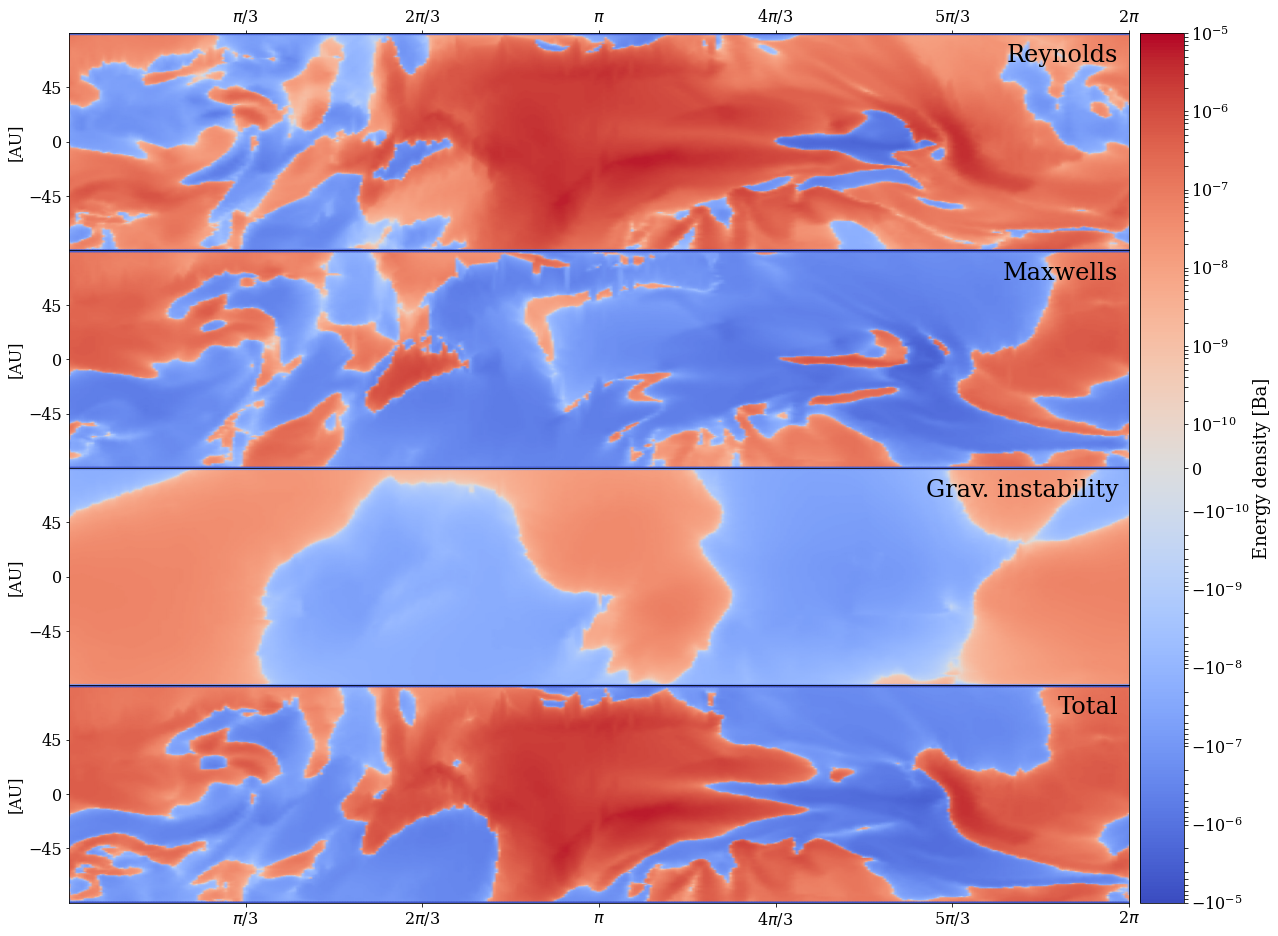

In [19]:
fig, axs = plt.subplots(4,1, figsize = (20,16))
for ax in axs.flatten():
    ax.set(ylabel = '[AU]', xlim = (0, 2*np.pi))

ytick = radius * data.au_length // 2

ax = axs[0]
ax.set_xticks(tick_values); ax.set_xticklabels(tick_labels); ax.xaxis.tick_top()

for ax in axs.flatten()[1:3]:
    ax.set_xticklabels([])
    
total_stress_R = reynolds_Ir + maxwell_Ir + grav_Ir
ax = axs[-1]
ax.set_xticks(tick_values); ax.set_xticklabels(tick_labels);
ax.pcolormesh(phinew_grid, znew_grid * data.au_length, total_stress_R.T, norm = colors.SymLogNorm(linthresh=1e-10, linscale=0.5, vmin = -1e-5, vmax = 1e-5), snap = True, shading = 'gouraud', cmap = 'coolwarm')
ax.set_yticks([-ytick,0, ytick])
ax.text(0.99, 0.95, 'Total', transform=ax.transAxes, ha='right', va='top', fontsize = 24)


for ax, stress, name in zip(axs.flatten(), [reynolds_Ir, maxwell_Ir, grav_Ir], stress_names):
    cs = ax.pcolormesh(phinew_grid, znew_grid * data.au_length, stress.T, norm = colors.SymLogNorm(linthresh=1e-10, linscale=0.5, vmin = -1e-5, vmax = 1e-5), snap = True, shading = 'gouraud', cmap = 'coolwarm')
    ax.set_yticks([-ytick,0, ytick])
    ax.text(0.99, 0.95, name, transform=ax.transAxes, ha='right', va='top', fontsize = 24)


fig.subplots_adjust(wspace=0, hspace=0)
cbar = fig.colorbar(cs, ax=axs.ravel().tolist(), fraction = 0.04, pad = 0.01)
cbar.set_label('Energy density [Ba]',fontsize = 18)



# Vertical part
# Calculating the all the differnt component of anguluar momentum loss in the vertical direction

### Mechanical (Raynolds stress):
#### $$F_v^{Reynolds}(R)=\mp\int_{0}^{R}dr \int_0^{2\pi}r^2d\phi \rho v_\phi(r,\phi,\pm h/2)v_z(r,\phi,\pm h/2)$$

### Magnetically induced transport (Maxwell stress)
#### $$F_v^{Maxwell}(R)=\pm\int_{0}^{R}dr \int_0^{2\pi}r^2d\phi \frac{B_\phi(r,\phi,\pm h/2)B_z(r,\phi,\pm h/2)}{4\pi}$$

### Transport associated with the gravitational potential $\nabla\Phi^2$ (transport through spiral arms and similar nonaxisymmetric structures)
#### $$F_v^{Grav.}(R)=-\int_{0}^{R}dr \int_0^{2\pi}r^2d\phi \frac{(\nabla\Phi)_\phi(r,\phi,\pm h/2)(\nabla\Phi)_z(r,\phi,\pm h/2)}{4\pi G}$$

# Doing the top part first

In [20]:
radius = 90
height = radius
refine_grid = 2
Nr = 200
N_phi = 100
G_cgs = G.to('cm**3 / (g * s**2)').value
radius /= data.au_length; height /= data.au_length
selection_radius = np.sqrt(radius**2 + height**2) * 2 
shell_Δ = 1; shell_Δ /= data.au_length

pp = [p for p in data.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]
w= np.array([p.level for p in pp]).argsort()[::-1]
sorted_patches = [pp[w[i]] for i in range(len(pp))]

extracted_values =  {key: [] for key in range(7)} # So far this is only for densities and velocities

for p in tqdm.tqdm(sorted_patches):
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [ n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
    if len(leafs) == 8: continue

    to_extract = (p.cyl_z > height - shell_Δ) & (p.cyl_z <  height + shell_Δ)
    p.B = np.concatenate([p.var(f'b'+axis)[None,...] for axis in ['x','y','z']], axis = 0)
    p.gradφ = np.array(np.gradient(p.var('phi'), p.ds[0], edge_order = 2))
    p.Bφ = np.sum(p.B * p.e_φ, axis = 0)
    p.Bz = np.sum(p.B * data.L[:,None, None, None], axis = 0)
    p.vφ = np.sum(p.vrel * p.e_φ, axis = 0)
    p.vz = np.sum(p.vrel * data.L[:,None, None, None], axis = 0)
    p.gradφ_φ = np.sum(p.gradφ * p.e_φ, axis = 0)
    p.gradφ_z = np.sum(p.gradφ * data.L[:,None, None, None], axis = 0)
    
    
    for lp in leafs: 
        leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
        covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
        to_extract *= covered_bool 
    
    r_coor = p.cyl_R[to_extract].T 
    φ_coor = p.φ[to_extract].T
    vel_φz = p.vz[to_extract].T * p.vφ[to_extract].T
    B_φz =  p.Bz[to_extract].T * p.Bφ[to_extract].T
    mass_val = p.m[to_extract].T 
    gradφ_φz = p.gradφ_r[to_extract].T * p.gradφ_z[to_extract].T
       
    extracted_values[0].extend(r_coor.tolist())
    extracted_values[1].extend(φ_coor.tolist())
    extracted_values[2].extend(vel_φz.tolist())
    extracted_values[3].extend(mass_val.tolist())
    extracted_values[4].extend(p.ds[0]**3 * np.ones(len(mass_val)))
    extracted_values[5].extend(B_φz.tolist())
    extracted_values[6].extend(gradφ_φz.tolist())

for key in extracted_values:
    extracted_values[key] = np.array(extracted_values[key])

#Making grid in height and phi direction:
r_grid = np.logspace(np.log10(1e-3 / data.au_length), np.log10(radius), Nr); phi_grid = np.linspace(0, 2 * np.pi, N_phi)

#Binning values
hist_mass, binedges_phi, binedges_r = np.histogram2d(extracted_values[1], extracted_values[0], bins = (phi_grid, r_grid), weights = extracted_values[3])
hist_vol, _, _ =  np.histogram2d(extracted_values[1], extracted_values[0], bins = (phi_grid, r_grid), weights = extracted_values[4])
hist_vφvz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[2] * extracted_values[3])[0] / hist_mass 
hist_BφBz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[5] * extracted_values[3])[0] / hist_mass 
hist_gradφ_φz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[6] * extracted_values[3])[0] / hist_mass 

hist_ρ = hist_mass/hist_vol
reynolds_vertical = - hist_vφvz * hist_ρ * data.cms_velocity**2 * data.cgs_density
maxwell_vertical = hist_BφBz / (4 * np.pi) * data.sn.scaling.b**2
grav_vertical = - hist_gradφ_φz / (4 * np.pi * G_cgs) * (data.cms_velocity / data.sn.scaling.t)**2

r_bins = r_grid[:-1] + 0.5 * np.diff(binedges_r)
phi_bins = phi_grid[:-1] + 0.5 * np.diff(binedges_phi)


rnew_grid =np.logspace(np.log10(1e-3 / data.au_length), np.log10(radius), Nr * refine_grid); phinew_grid = np.linspace(0, 2 * np.pi, N_phi * refine_grid)

reynolds_Iv = fill_2Dhist(reynolds_vertical, orig_coor=[phi_bins, r_bins], new_coor=[phinew_grid, rnew_grid], periodic_x=True)
maxwell_Iv = fill_2Dhist(maxwell_vertical, orig_coor=[phi_bins, r_bins], new_coor=[phinew_grid, rnew_grid], periodic_x=True)
grav_Iv = fill_2Dhist(grav_vertical, orig_coor=[phi_bins, r_bins], new_coor=[phinew_grid, rnew_grid], periodic_x=True)

 25%|██▌       | 347/1376 [00:00<00:00, 1152.08it/s]

100%|██████████| 1376/1376 [00:01<00:00, 1093.70it/s]
/tmp/ipykernel_733029/2959479334.py:63: RuntimeWarning: invalid value encountered in true_divide
  hist_vφvz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[2] * extracted_values[3])[0] / hist_mass
/tmp/ipykernel_733029/2959479334.py:64: RuntimeWarning: invalid value encountered in true_divide
  hist_BφBz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[5] * extracted_values[3])[0] / hist_mass
/tmp/ipykernel_733029/2959479334.py:65: RuntimeWarning: invalid value encountered in true_divide
  hist_gradφ_φz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[6] * extracted_values[3])[0] / hist_mass
/tmp/ipykernel_733029/2959479334.py:67: RuntimeWarning: invalid value encountered in true_divide
  hist_ρ = hist_mass/hist_vol


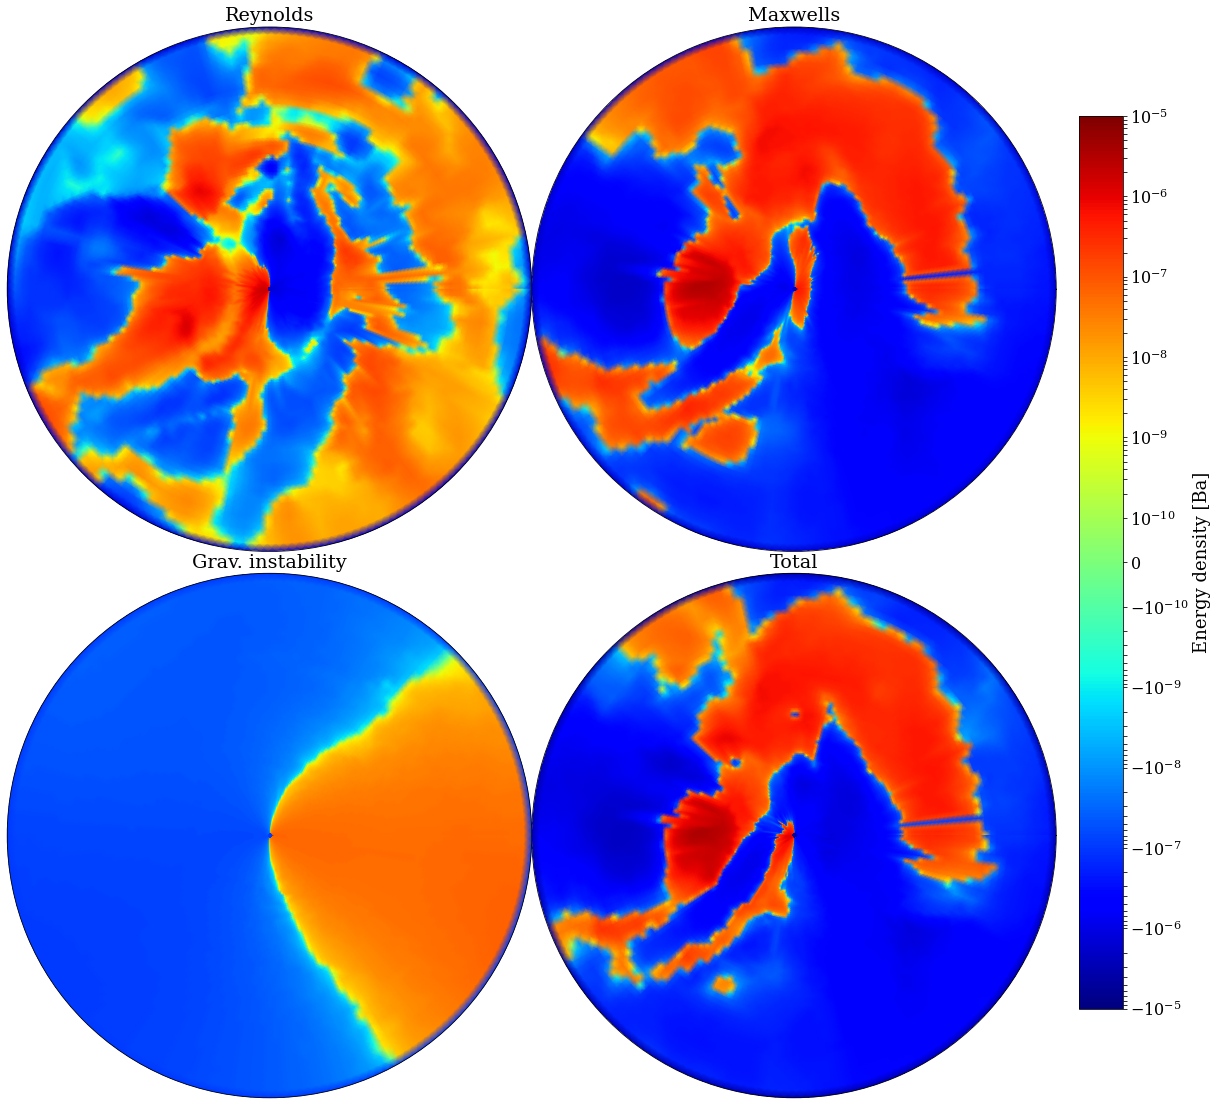

In [21]:
fig, axs = plt.subplots(2,2, figsize = (20,20), subplot_kw={'projection' :'polar'})

for ax in axs.flatten():
    ax.set_xticks([]); ax.set_xticklabels([])
    ax.set_yticks([])
    
total_stress_V = reynolds_Iv + maxwell_Iv + grav_Iv
ax = axs.flatten()[-1]
ax.set_xticks([]); ax.set_xticklabels([]);
ax.pcolormesh(phinew_grid, rnew_grid * data.au_length, total_stress_V.T, norm = colors.SymLogNorm(linthresh=1e-10, linscale=0.5, vmin = -1e-5, vmax = 1e-5), snap = True, shading = 'gouraud', cmap = 'jet')
ax.set(title = 'Total')

for ax, stress, name in zip(axs.flatten(), [reynolds_Iv, maxwell_Iv, grav_Iv], stress_names):

    cs = ax.pcolormesh(phinew_grid, rnew_grid * data.au_length, stress.T, norm = colors.SymLogNorm(linthresh=1e-10, linscale=0.5, vmin = -1e-5, vmax = 1e-5), shading = 'gouraud', snap = True, cmap = 'jet')
    ax.set(title = name)
    #ax.text(0.99, 0.95, name, transform=ax.transAxes, ha='right', va='top', fontsize = 24)


fig.subplots_adjust(wspace=0, hspace=0.01)
cbar = fig.colorbar(cs, ax=axs.ravel().tolist(), fraction = 0.04, pad = 0.02)
cbar.set_label('Energy density [Ba]',fontsize = 18)



# Then the bottom

In [22]:
radius = 90
height = radius
G_cgs = G.to('cm**3 / (g * s**2)').value
radius /= data.au_length; height /= data.au_length
selection_radius = np.sqrt(radius**2 + height**2) * 2 
shell_Δ = 1; shell_Δ /= data.au_length

pp = [p for p in data.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]
w= np.array([p.level for p in pp]).argsort()[::-1]
sorted_patches = [pp[w[i]] for i in range(len(pp))]

extracted_values =  {key: [] for key in range(7)} # So far this is only for densities and velocities

for p in tqdm.tqdm(sorted_patches):
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [ n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
    if len(leafs) == 8: continue

    to_extract = (p.cyl_z > - height - shell_Δ) & (p.cyl_z < - height + shell_Δ)
    p.B = np.concatenate([p.var(f'b'+axis)[None,...] for axis in ['x','y','z']], axis = 0)
    p.gradφ = np.array(np.gradient(p.var('phi'), p.ds[0], edge_order = 2))
    p.Bφ = np.sum(p.B * p.e_φ, axis = 0)
    p.Bz = np.sum(p.B * data.L[:,None, None, None], axis = 0)
    p.vφ = np.sum(p.vrel * p.e_φ, axis = 0)
    p.vz = np.sum(p.vrel * data.L[:,None, None, None], axis = 0)
    p.gradφ_φ = np.sum(p.gradφ * p.e_φ, axis = 0)
    p.gradφ_z = np.sum(p.gradφ * data.L[:,None, None, None], axis = 0)
    
    
    for lp in leafs: 
        leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
        covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
        to_extract *= covered_bool 
    
    r_coor = p.cyl_R[to_extract].T 
    φ_coor = p.φ[to_extract].T
    vel_φz = p.vz[to_extract].T * p.vφ[to_extract].T
    B_φz =  p.Bz[to_extract].T * p.Bφ[to_extract].T
    mass_val = p.m[to_extract].T 
    gradφ_φz = p.gradφ_r[to_extract].T * p.gradφ_z[to_extract].T
       
    extracted_values[0].extend(r_coor.tolist())
    extracted_values[1].extend(φ_coor.tolist())
    extracted_values[2].extend(vel_φz.tolist())
    extracted_values[3].extend(mass_val.tolist())
    extracted_values[4].extend(p.ds[0]**3 * np.ones(len(mass_val)))
    extracted_values[5].extend(B_φz.tolist())
    extracted_values[6].extend(gradφ_φz.tolist())

for key in extracted_values:
    extracted_values[key] = np.array(extracted_values[key])

#Making grid in height and phi direction:
r_grid = np.logspace(np.log10(1e-3 / data.au_length), np.log10(radius), Nr); phi_grid = np.linspace(0, 2 * np.pi, N_phi)

#Binning values
hist_mass, binedges_phi, binedges_r = np.histogram2d(extracted_values[1], extracted_values[0], bins = (phi_grid, r_grid), weights = extracted_values[3])
hist_vol, _, _ =  np.histogram2d(extracted_values[1], extracted_values[0], bins = (phi_grid, r_grid), weights = extracted_values[4])
hist_vφvz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[2] * extracted_values[3])[0] / hist_mass 
hist_BφBz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[5] * extracted_values[3])[0] / hist_mass 
hist_gradφ_φz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[6] * extracted_values[3])[0] / hist_mass 

hist_ρ = hist_mass/hist_vol
reynolds_vertical = hist_vφvz * hist_ρ * data.cms_velocity**2 * data.cgs_density
maxwell_vertical = - hist_BφBz / (4 * np.pi) * data.sn.scaling.b**2
grav_vertical = hist_gradφ_φz / (4 * np.pi * G_cgs) * (data.cms_velocity / data.sn.scaling.t)**2

r_bins = r_grid[:-1] + 0.5 * np.diff(binedges_r)
phi_bins = phi_grid[:-1] + 0.5 * np.diff(binedges_phi)


rnew_grid =np.logspace(np.log10(1e-3 / data.au_length), np.log10(radius), Nr * refine_grid); 
#rnew_grid = np.linspace(0.03 / data.au_length, radius, Nr * refine_grid)
phinew_grid = np.linspace(0, 2 * np.pi, N_phi * refine_grid)

reynolds_Iv = fill_2Dhist(reynolds_vertical, orig_coor=[phi_bins, r_bins], new_coor=[phinew_grid, rnew_grid], periodic_x=True)
maxwell_Iv = fill_2Dhist(maxwell_vertical, orig_coor=[phi_bins, r_bins], new_coor=[phinew_grid, rnew_grid], periodic_x=True)
grav_Iv = fill_2Dhist(grav_vertical, orig_coor=[phi_bins, r_bins], new_coor=[phinew_grid, rnew_grid], periodic_x=True)

 17%|█▋        | 229/1376 [00:00<00:01, 1141.37it/s]

100%|██████████| 1376/1376 [00:01<00:00, 1104.88it/s]
/tmp/ipykernel_733029/128281367.py:60: RuntimeWarning: invalid value encountered in true_divide
  hist_vφvz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[2] * extracted_values[3])[0] / hist_mass
/tmp/ipykernel_733029/128281367.py:61: RuntimeWarning: invalid value encountered in true_divide
  hist_BφBz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[5] * extracted_values[3])[0] / hist_mass
/tmp/ipykernel_733029/128281367.py:62: RuntimeWarning: invalid value encountered in true_divide
  hist_gradφ_φz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[6] * extracted_values[3])[0] / hist_mass
/tmp/ipykernel_733029/128281367.py:64: RuntimeWarning: invalid value encountered in true_divide
  hist_ρ = hist_mass/hist_vol


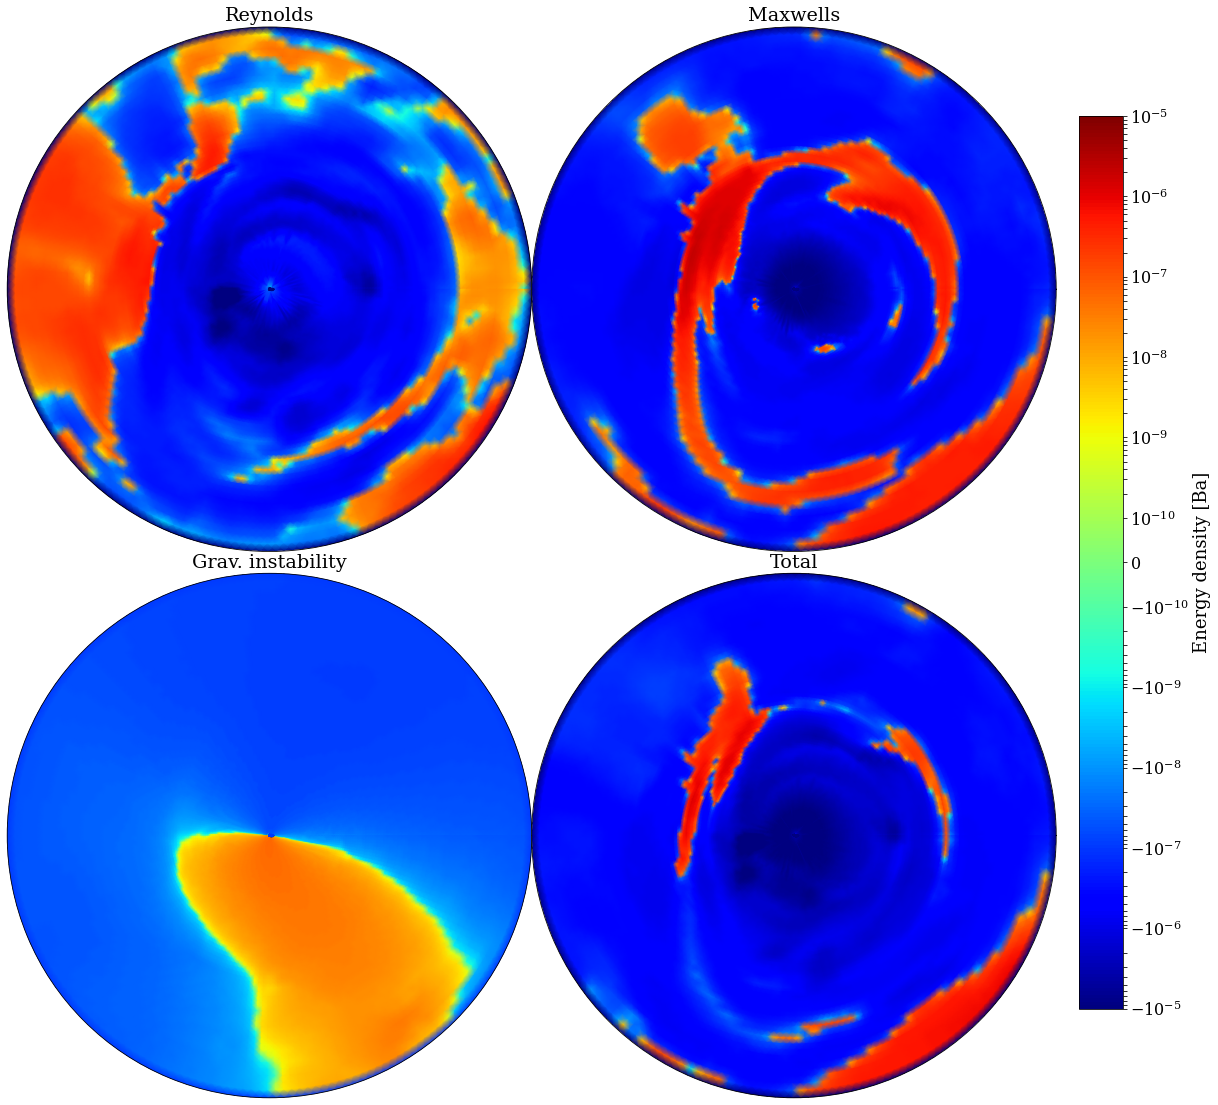

In [23]:
fig, axs = plt.subplots(2,2, figsize = (20,20), subplot_kw={'projection' :'polar'})

for ax in axs.flatten():
    ax.set_xticks([]); ax.set_xticklabels([])
    ax.set_yticks([])
    
total_stress_V = reynolds_Iv + maxwell_Iv + grav_Iv
ax = axs.flatten()[-1]
ax.set_xticks([]); ax.set_xticklabels([]);
ax.pcolormesh(phinew_grid, rnew_grid * data.au_length, total_stress_V.T, norm = colors.SymLogNorm(linthresh=1e-10, linscale=0.5, vmin = -1e-5, vmax = 1e-5), snap = True, shading = 'gouraud', cmap = 'jet')
ax.set(title = 'Total')

for ax, stress, name in zip(axs.flatten(), [reynolds_Iv, maxwell_Iv, grav_Iv], stress_names):
    cs = ax.pcolormesh(phinew_grid, rnew_grid * data.au_length, stress.T, norm = colors.SymLogNorm(linthresh=1e-10, linscale=0.5, vmin = -1e-5, vmax = 1e-5), snap = True, shading = 'gouraud', cmap = 'jet')
    ax.set(title = name)
    #ax.text(0.99, 0.95, name, transform=ax.transAxes, ha='right', va='top', fontsize = 24)


fig.subplots_adjust(wspace=0, hspace=0.01)
cbar = fig.colorbar(cs, ax=axs.ravel().tolist(), fraction = 0.04, pad = 0.02)
cbar.set_label('Energy density [Ba]',fontsize = 18)



# Both top and bottom

In [24]:
radius = 90
height = radius
G_cgs = G.to('cm**3 / (g * s**2)').value
radius /= data.au_length; height /= data.au_length
selection_radius = np.sqrt(radius**2 + height**2) * 2 
shell_Δ = 1; shell_Δ /= data.au_length


for top in [1, 0]:
    pp = [p for p in data.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]
    w= np.array([p.level for p in pp]).argsort()[::-1]
    sorted_patches = [pp[w[i]] for i in range(len(pp))]


    extracted_values =  {key: [] for key in range(7)} # So far this is only for densities and velocities

    for p in tqdm.tqdm(sorted_patches):
        nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
        children = [ n for n in nbors if n.level == p.level + 1]
        leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
        if len(leafs) == 8: continue

        if top == True:
            to_extract = (p.cyl_z > height - shell_Δ) & (p.cyl_z <  height + shell_Δ)
        elif top == False:
            to_extract = (p.cyl_z > - height - shell_Δ) & (p.cyl_z < - height + shell_Δ)
        
        p.B = np.concatenate([p.var(f'b'+axis)[None,...] for axis in ['x','y','z']], axis = 0)
        p.gradφ = np.array(np.gradient(p.var('phi'), p.ds[0], edge_order = 2))
        p.Bφ = np.sum(p.B * p.e_φ, axis = 0)
        p.Bz = np.sum(p.B * data.L[:,None, None, None], axis = 0)
        p.vφ = np.sum(p.vrel * p.e_φ, axis = 0)
        p.vz = np.sum(p.vrel * data.L[:,None, None, None], axis = 0)
        p.gradφ_φ = np.sum(p.gradφ * p.e_φ, axis = 0)
        p.gradφ_z = np.sum(p.gradφ * data.L[:,None, None, None], axis = 0)
        
        for lp in leafs: 
            leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
            covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
            to_extract *= covered_bool 
        
        r_coor = p.cyl_R[to_extract].T 
        φ_coor = p.φ[to_extract].T
        vel_φz = p.vz[to_extract].T * p.vφ[to_extract].T
        B_φz =  p.Bz[to_extract].T * p.Bφ[to_extract].T
        mass_val = p.m[to_extract].T 
        gradφ_φz = p.gradφ_r[to_extract].T * p.gradφ_z[to_extract].T
        
        extracted_values[0].extend(r_coor.tolist())
        extracted_values[1].extend(φ_coor.tolist())
        extracted_values[2].extend(vel_φz.tolist())
        extracted_values[3].extend(mass_val.tolist())
        extracted_values[4].extend(p.ds[0]**3 * np.ones(len(mass_val)))
        extracted_values[5].extend(B_φz.tolist())
        extracted_values[6].extend(gradφ_φz.tolist())

    for key in extracted_values:
        extracted_values[key] = np.array(extracted_values[key])

    #Making grid in height and phi direction:
    r_grid = np.logspace(np.log10(1e-3 / data.au_length), np.log10(radius), Nr); phi_grid = np.linspace(0, 2 * np.pi, N_phi)

    #Binning values
    hist_mass, binedges_phi, binedges_r = np.histogram2d(extracted_values[1], extracted_values[0], bins = (phi_grid, r_grid), weights = extracted_values[3])
    hist_vol, _, _ =  np.histogram2d(extracted_values[1], extracted_values[0], bins = (phi_grid, r_grid), weights = extracted_values[4])
    hist_vφvz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[2] * extracted_values[3])[0] / hist_mass 
    hist_BφBz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[5] * extracted_values[3])[0] / hist_mass 
    hist_gradφ_φz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[6] * extracted_values[3])[0] / hist_mass 

    hist_ρ = hist_mass/hist_vol
    if top == True:
        reynolds_vertical = - hist_vφvz * hist_ρ * data.cms_velocity**2 * data.cgs_density
        maxwell_vertical = hist_BφBz / (4 * np.pi) * data.sn.scaling.b**2
        grav_vertical = - hist_gradφ_φz / (4 * np.pi * G_cgs) * (data.cms_velocity / data.sn.scaling.t)**2
        
    elif top == False:
        reynolds_vertical = hist_vφvz * hist_ρ * data.cms_velocity**2 * data.cgs_density
        maxwell_vertical = - hist_BφBz / (4 * np.pi) * data.sn.scaling.b**2
        grav_vertical = hist_gradφ_φz / (4 * np.pi * G_cgs) * (data.cms_velocity / data.sn.scaling.t)**2

    r_bins = r_grid[:-1] + 0.5 * np.diff(binedges_r)
    phi_bins = phi_grid[:-1] + 0.5 * np.diff(binedges_phi)


    rnew_grid =np.logspace(np.log10(1e-3 / data.au_length), np.log10(radius), Nr * refine_grid); 
    #rnew_grid = np.linspace(0.03 / data.au_length, radius, Nr * refine_grid)
    phinew_grid = np.linspace(0, 2 * np.pi, N_phi * refine_grid)

    if top == True:
        reynolds_Iv = fill_2Dhist(reynolds_vertical, orig_coor=[phi_bins, r_bins], new_coor=[phinew_grid, rnew_grid], periodic_x=True)
        maxwell_Iv = fill_2Dhist(maxwell_vertical, orig_coor=[phi_bins, r_bins], new_coor=[phinew_grid, rnew_grid], periodic_x=True)
        grav_Iv = fill_2Dhist(grav_vertical, orig_coor=[phi_bins, r_bins], new_coor=[phinew_grid, rnew_grid], periodic_x=True)

    elif top == False:
        reynolds_Iv += fill_2Dhist(reynolds_vertical, orig_coor=[phi_bins, r_bins], new_coor=[phinew_grid, rnew_grid], periodic_x=True)
        maxwell_Iv += fill_2Dhist(maxwell_vertical, orig_coor=[phi_bins, r_bins], new_coor=[phinew_grid, rnew_grid], periodic_x=True)
        grav_Iv += fill_2Dhist(grav_vertical, orig_coor=[phi_bins, r_bins], new_coor=[phinew_grid, rnew_grid], periodic_x=True)

 16%|█▋        | 224/1376 [00:00<00:01, 1112.29it/s]

100%|██████████| 1376/1376 [00:01<00:00, 1102.21it/s]
/tmp/ipykernel_733029/3700448365.py:66: RuntimeWarning: invalid value encountered in true_divide
  hist_vφvz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[2] * extracted_values[3])[0] / hist_mass
/tmp/ipykernel_733029/3700448365.py:67: RuntimeWarning: invalid value encountered in true_divide
  hist_BφBz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[5] * extracted_values[3])[0] / hist_mass
/tmp/ipykernel_733029/3700448365.py:68: RuntimeWarning: invalid value encountered in true_divide
  hist_gradφ_φz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[6] * extracted_values[3])[0] / hist_mass
/tmp/ipykernel_733029/3700448365.py:70: RuntimeWarning: invalid value encountered in true_divide
  hist_ρ = hist_mass/hist_vol
100%|██████████| 1376/1

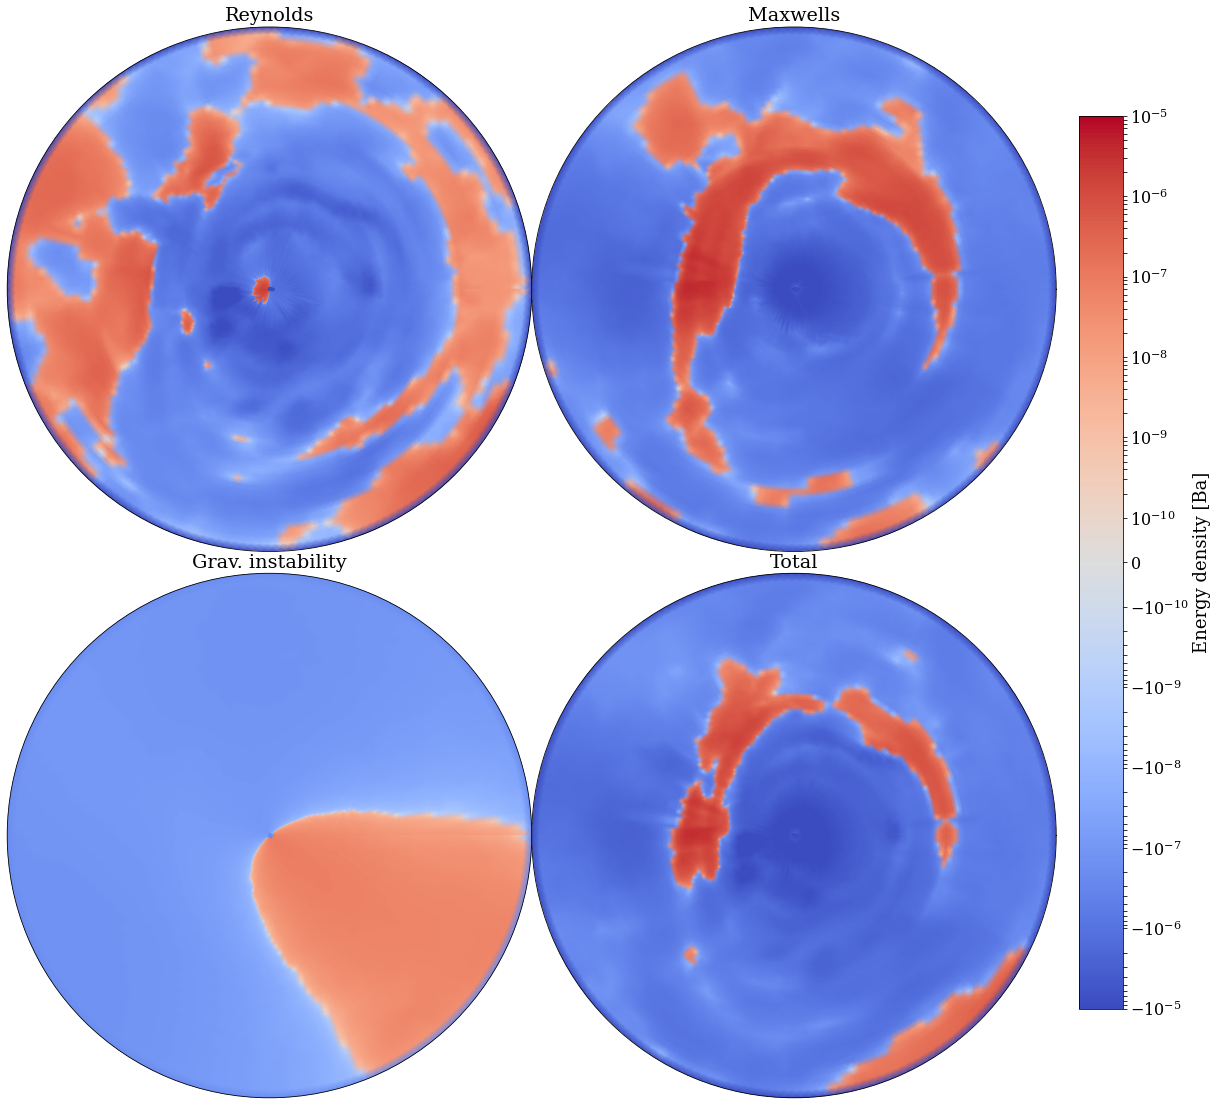

In [25]:
fig, axs = plt.subplots(2,2, figsize = (20,20), subplot_kw={'projection' :'polar'})

for ax in axs.flatten():
    ax.set_xticks([]); ax.set_xticklabels([])
    ax.set_yticks([])
    
total_stress_V = reynolds_Iv + maxwell_Iv + grav_Iv
ax = axs.flatten()[-1]
ax.set_xticks([]); ax.set_xticklabels([]);
ax.pcolormesh(phinew_grid, rnew_grid * data.au_length, total_stress_V.T, norm = colors.SymLogNorm(linthresh=1e-10, linscale=0.5, vmin = -1e-5, vmax = 1e-5), snap = True, shading = 'gouraud', cmap = 'coolwarm')
ax.set(title = 'Total')

for ax, stress, name in zip(axs.flatten(), [reynolds_Iv, maxwell_Iv, grav_Iv], stress_names):
    cs = ax.pcolormesh(phinew_grid, rnew_grid * data.au_length, stress.T, norm = colors.SymLogNorm(linthresh=1e-10, linscale=0.5, vmin = -1e-5, vmax = 1e-5), snap = True, shading = 'gouraud', cmap = 'coolwarm')
    ax.set(title = name)
    #ax.text(0.99, 0.95, name, transform=ax.transAxes, ha='right', va='top', fontsize = 24)


fig.subplots_adjust(wspace=0, hspace=0.01)
cbar = fig.colorbar(cs, ax=axs.ravel().tolist(), fraction = 0.04, pad = 0.02)
cbar.set_label('Energy density [Ba]',fontsize = 18)



In [26]:
r = rnew_grid * data.sn.scaling.l
ΔL_Rv = simps(simps(reynolds_Iv * r**2, phinew_grid, axis = 0), r)
ΔL_Mv = simps(simps(maxwell_Iv * r**2, phinew_grid, axis = 0), r)
ΔL_Gv = simps(simps(grav_Iv * r**2, phinew_grid, axis = 0), r)
ΔL_Rv, ΔL_Mv, ΔL_Gv, ΔL_Rv + ΔL_Mv + ΔL_Gv

(-6.186399443381168e+39,
 -4.661017508188946e+39,
 -3.452503795125292e+38,
 -1.1192667331082643e+40)

In [27]:
5.708497856101492e+39 + -1.1192667331082643e+40

-5.484169474981151e+39

In [28]:
1/0

ZeroDivisionError: division by zero